# Задача 3. Сравнение методов классификации

* **Дедлайн**: 20.11.2023, 23:59
* **Основной полный балл**: 5
* **Максимум баллов**: 10

## Задача

- [x] Самостоятельно реализовать один из методов классификации, с возможностью настройки гиперпараметров.
- [x] Взять данные для предсказания заболеваний сердца [тут](https://github.com/rustam-azimov/ml-course/tree/main/data/heart_disease) (целевой признак для предсказания --- **target**). Демо блокнот с анализом этих данных можно найти [тут](https://github.com/rustam-azimov/ml-course/blob/main/practice/practice07_knn_nb/practice07_part02_classification_heart_disease_demo.ipynb).
- [x] Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (**Data Cleaning**).
- [x] Выполнить разведочный анализ (**EDA**), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи классификации.
- [x] При необходимости выполнить полезные преобразования данных (например, трансформировать категариальные признаки в количественные), убрать ненужные признаки, создать новые (**Feature Engineering**).
- [x] Используя **подбор гиперпараметров**, **кросс-валидацию** и при необходимости **масштабирование данных**, добиться наилучшего качества предсказания от Вашей реализации на выделенной заранее тестовой выборке.
- [x] Повторить предыдущий пункт для библиотечных реализаций (например, из **sklearn**) всех пройденных методов классификации (**logistic regression, svm, knn, naive bayes, decision tree**).
- [x] Сравнить все обученные модели, построить их **confusion matrices**. Сделать выводы о полученных моделях в рамках решения задачи классификации на выбранных данных.
- [x] * (**+2 балла**) Реализовать еще один из методов классификации и добавить его в сравнение.
- [-] * (**+3 балла**) Найти данные, на которых интересно будет решать задачу классификации. Повторить все пункты задания на новых данных.

In [560]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd
import seaborn as sns
from scipy.special import expit

from numbers import Integral, Real

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.estimator_checks import check_estimator
from sklearn.utils.multiclass import check_classification_targets
from sklearn.utils.validation import (
    check_scalar, check_X_y, check_array, check_is_fitted
)


# Реализация методов классификации

В качестве методов классификации использует логистическую регрессия и KNN классификатор.

In [561]:
class KNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors = 5):
        self.n_neighbors = n_neighbors

    def fit(self, X, y):
        self.n_neighbors = check_scalar(self.n_neighbors, "n_neighbors", Integral, min_val=1)
        self.X_, self.y_ = check_X_y(X, y)
        check_classification_targets(self.y_)
        self.n_features_in_ = self.X_.shape[1]
        self.classes_ = np.unique(self.y_)
        return self

    def predict(self, X: npt.ArrayLike) -> npt.NDArray:
        check_is_fitted(self)
        X = check_array(X)

        result = np.empty((X.shape[0],), dtype=self.y_.dtype)
        for i, x in enumerate(X):
            dists = np.linalg.norm(self.X_ - x, axis=1)
            sorted_dists_idx = np.argsort(dists)
            neighbor_classes = self.y_[sorted_dists_idx][:self.n_neighbors]
            elems, counts = np.unique(neighbor_classes, return_counts=True)
            result[i] = elems[np.argmax(counts)]
        return result


In [562]:
class LogRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, alpha = 1, *, max_iter = 1000, tol = 1e-4, eta0 = 1):
        self.alpha = alpha
        self.max_iter = max_iter
        self.tol = tol
        self.eta0 = eta0

    def fit(self, X, y):
        self.alpha = check_scalar(self.alpha, "alpha", Real, min_val=0.0)
        self.max_iter = check_scalar(self.max_iter, "max_iter", Integral, min_val=1)
        self.tol = check_scalar(self.tol, "tol", Real, min_val=0.0)
        self.eta0 = check_scalar(self.eta0, "eta0", Real, min_val=0, include_boundaries="neither")

        X, y = check_X_y(X, y)
        check_classification_targets(y)

        self.classes_ = np.unique(y)
        self.n_features_in_ = X.shape[1]
        X = np.column_stack([X, np.ones(X.shape[0])])

        self.coef_ = np.empty((self.classes_.size, self.n_features_in_))
        self.intercept_ = np.empty((self.classes_.size,))
        self.n_iter_ = np.empty((self.classes_.size,))
        for i, c in enumerate(self.classes_):
            coef = np.zeros(X.shape[1])

            grad = np.inf
            n_iter = 0
            while n_iter < self.max_iter and np.linalg.norm(grad) > self.tol:
                pred = expit(X @ coef)
                grad = X.T @ (pred - (y == c)) + 2 * self.alpha * np.pad(coef[:-1], (0, 1))
                n_iter += 1
                coef -= grad * self.eta0 / n_iter

            self.coef_[i] = coef[:-1]
            self.intercept_[i] = coef[-1]
            self.n_iter_[i] = n_iter

        return self

    def predict(self, X: npt.ArrayLike) -> npt.NDArray:
        check_is_fitted(self)
        X = check_array(X)
        class_probs = expit(X @ self.coef_.T + self.intercept_)
        most_likely_class_idx = np.argmax(class_probs, axis=1)
        return self.classes_[most_likely_class_idx]


In [563]:
check_estimator(KNNClassifier())
check_estimator(LogRegression())


# Датасет

В качестве данных был взять датасет [heart.csv](https://www.kaggle.com/code/ahmedadell30/heart-disease-prediction-with-ann-models/data) для предсказания заболеваний сердца.

Описание датасета: <br>
* age - age in years <br>
* sex - (1 = male; 0 = female) <br>
* cp - chest pain type <br>
* trestbps - resting blood pressure (in mm Hg on admission to the hospital) <br>
* chol - serum cholestoral in mg/dl <br>
* fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false) <br>
* restecg - resting electrocardiographic results <br>
* thalach - maximum heart rate achieved <br>
* exang - exercise induced angina (1 = yes; 0 = no) <br>
* oldpeak - ST depression induced by exercise relative to rest <br>
* slope - the slope of the peak exercise ST segment <br>
* ca - number of major vessels (0-3) colored by flourosopy <br>
* thal - 1 = normal; 2 = fixed defect; 3 = reversable defect <br>
* target - have disease or not (1=yes, 0=no)

Необходимо решить задачу классификации и научиться предсказывать целовой признак **target** имеет ли пациент заболевание сердца.

In [564]:
df = pd.read_csv("../data/heart_disease/heart.csv")


In [565]:
df.isnull().sum()


age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [566]:
df.target.value_counts()


1    526
0    499
Name: target, dtype: int64

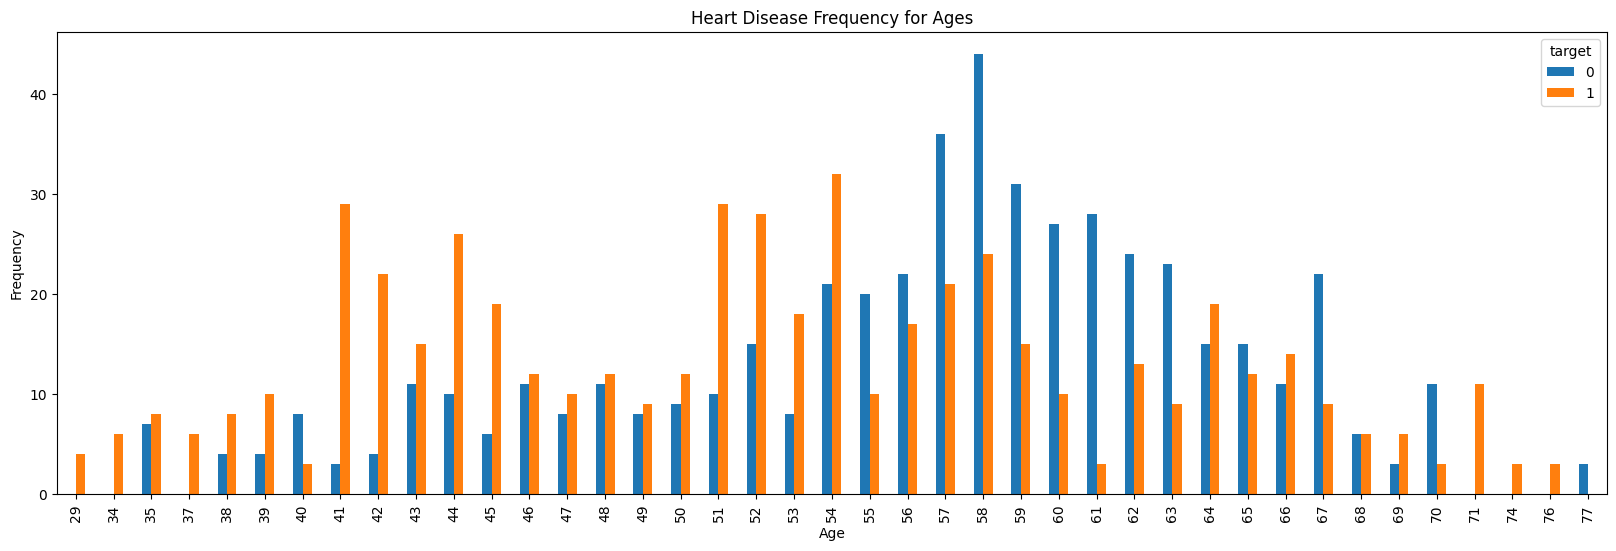

In [567]:
pd.crosstab(df.age,df.target).plot(kind="bar", figsize=(20, 6))
plt.title('Heart Disease Frequency for Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


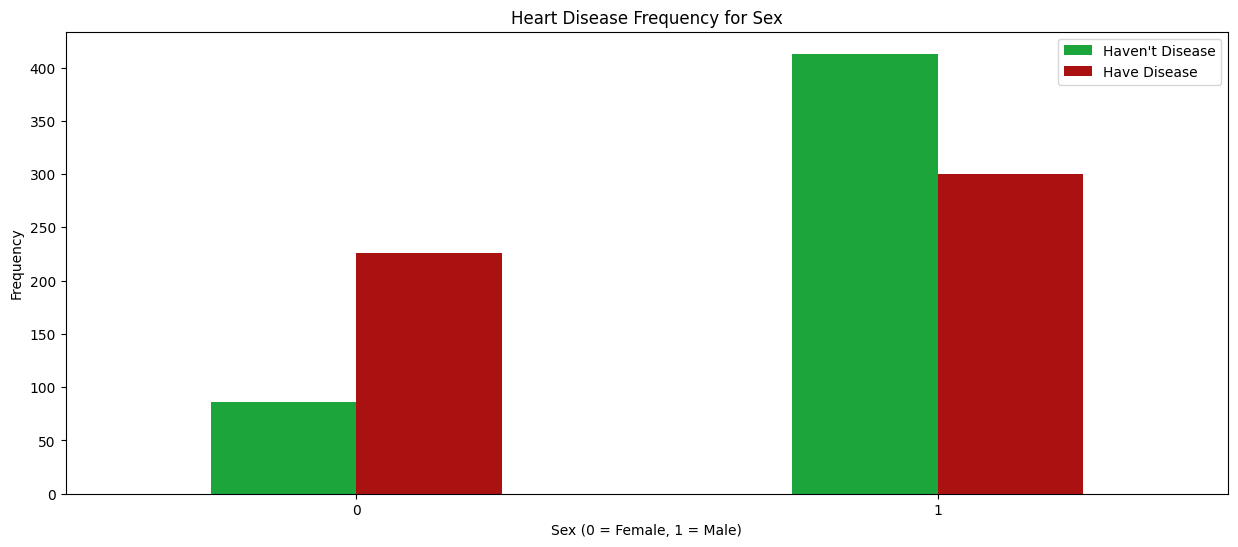

In [568]:
pd.crosstab(df.sex,df.target).plot(kind="bar", figsize=(15, 6), color=['#1CA53B', '#AA1111' ])
plt.title('Heart Disease Frequency for Sex')
plt.xlabel('Sex (0 = Female, 1 = Male)')
plt.xticks(rotation=0)
plt.legend(["Haven't Disease", "Have Disease"])
plt.ylabel('Frequency')
plt.show()


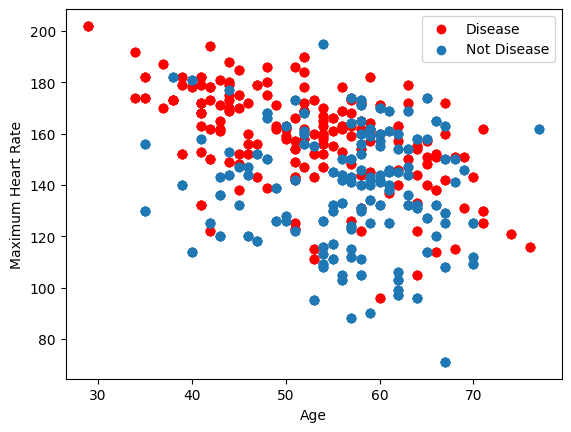

In [569]:
plt.scatter(x=df.age[df.target==1], y=df.thalach[(df.target==1)], c="red")
plt.scatter(x=df.age[df.target==0], y=df.thalach[(df.target==0)])
plt.legend(["Disease", "Not Disease"])
plt.xlabel("Age")
plt.ylabel("Maximum Heart Rate")
plt.show()


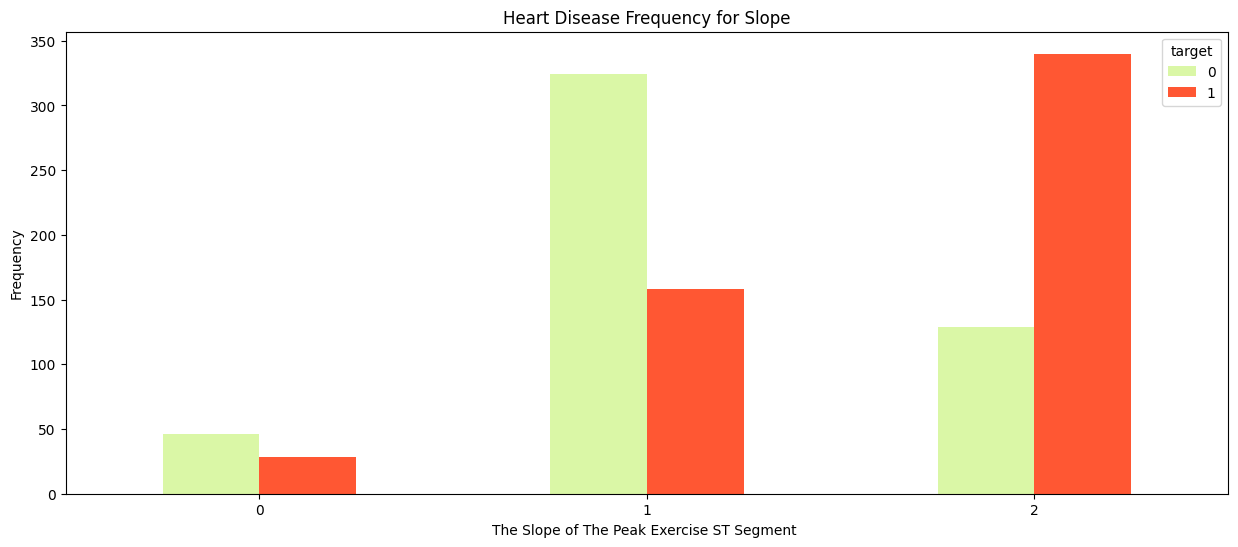

In [570]:
pd.crosstab(df.slope,df.target).plot(kind="bar", figsize=(15, 6), color=['#DAF7A6','#FF5733' ])
plt.title('Heart Disease Frequency for Slope')
plt.xlabel('The Slope of The Peak Exercise ST Segment ')
plt.xticks(rotation = 0)
plt.ylabel('Frequency')
plt.show()


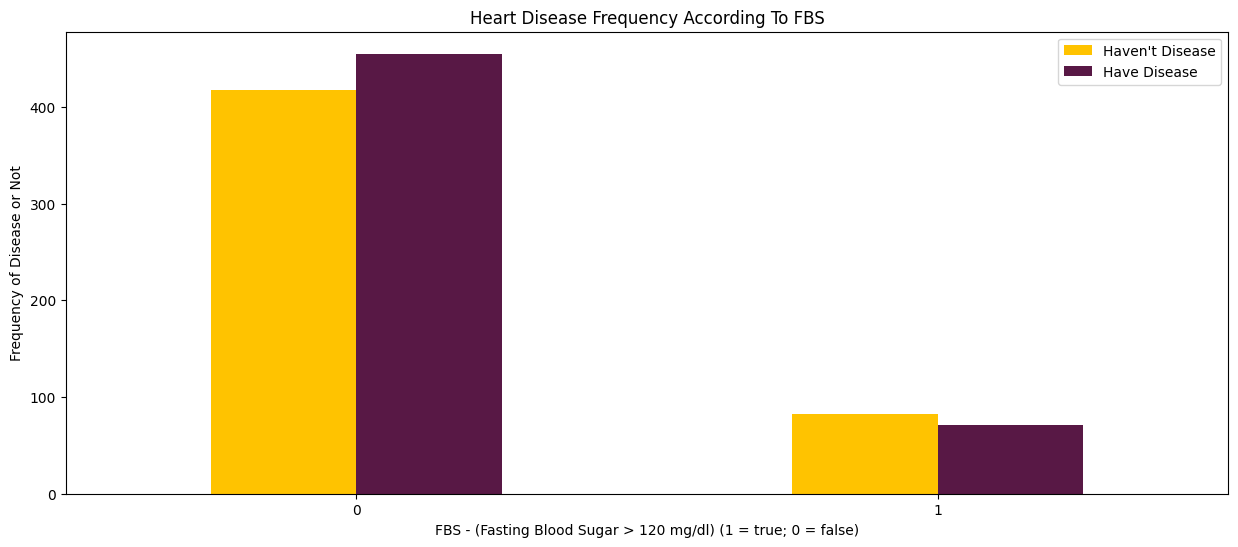

In [571]:
pd.crosstab(df.fbs,df.target).plot(kind="bar", figsize=(15, 6), color=['#FFC300','#581845' ])
plt.title('Heart Disease Frequency According To FBS')
plt.xlabel('FBS - (Fasting Blood Sugar > 120 mg/dl) (1 = true; 0 = false)')
plt.xticks(rotation = 0)
plt.legend(["Haven't Disease", "Have Disease"])
plt.ylabel('Frequency of Disease or Not')
plt.show()


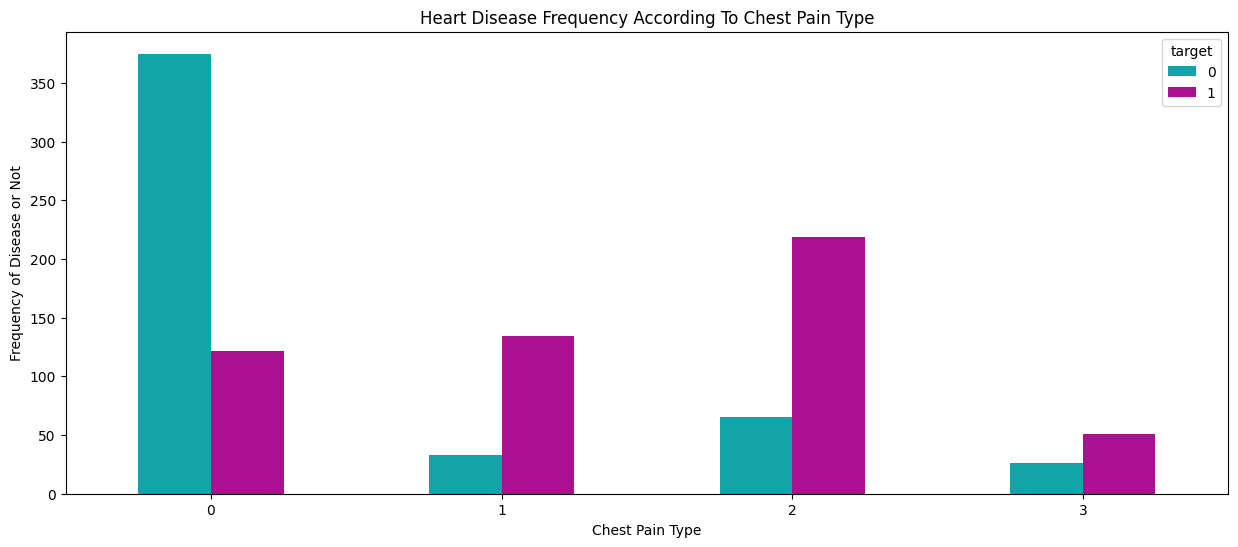

In [572]:
pd.crosstab(df.cp,df.target).plot(kind="bar",figsize=(15, 6), color=['#11A5AA','#AA1190' ])
plt.title('Heart Disease Frequency According To Chest Pain Type')
plt.xlabel('Chest Pain Type')
plt.xticks(rotation = 0)
plt.ylabel('Frequency of Disease or Not')
plt.show()


Преобразование категориальных признаков
Закодируем категориальные признаки cp, thal и slope.

In [573]:
cp_dum = pd.get_dummies(df['cp'], prefix = "cp")
thal_dum = pd.get_dummies(df['thal'], prefix = "thal")
slope_dum = pd.get_dummies(df['slope'], prefix = "slope")

frames = [df, cp_dum, thal_dum, slope_dum]
df = pd.concat(frames, axis = 1)
df.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,...,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2
0,52,1,0,125,212,0,1,168,0,1.0,...,0,0,0,0,0,0,1,0,0,1
1,53,1,0,140,203,1,0,155,1,3.1,...,0,0,0,0,0,0,1,1,0,0
2,70,1,0,145,174,0,1,125,1,2.6,...,0,0,0,0,0,0,1,1,0,0
3,61,1,0,148,203,0,1,161,0,0.0,...,0,0,0,0,0,0,1,0,0,1
4,62,0,0,138,294,1,1,106,0,1.9,...,0,0,0,0,0,1,0,0,1,0


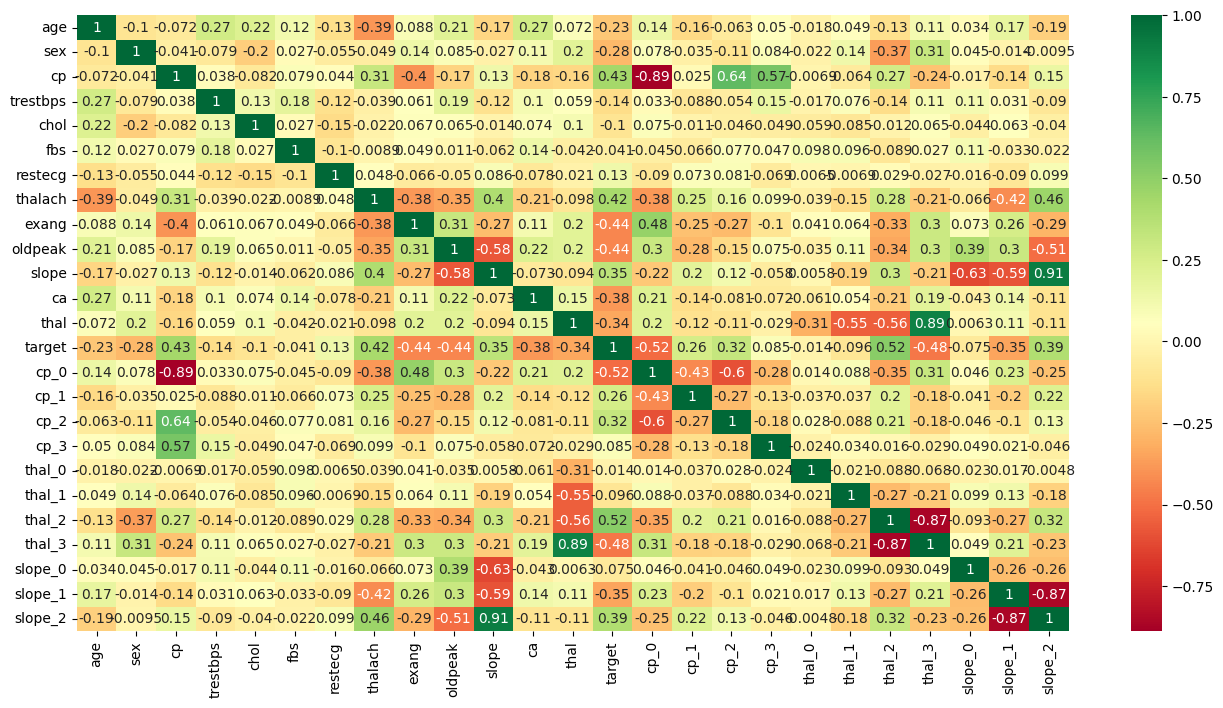

In [574]:
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn')
fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.show()


Уберём признаки, имеющие сильную корреляцию:

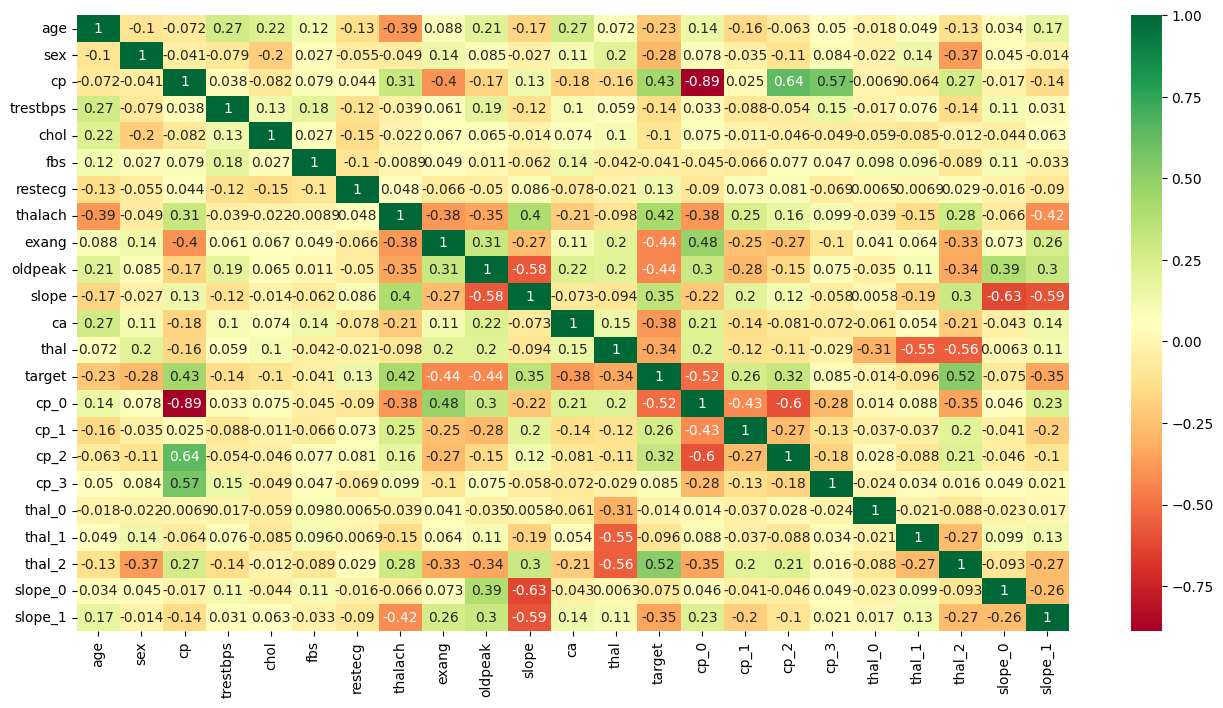

In [575]:
df = df.drop(columns = ['thal_3', 'slope_2'])
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn')
fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.show()


# Подготовка данных

In [576]:
X = df.drop(columns=["target"])
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, random_state=42, stratify=y)


Для данного датасета наша задача - точно выявлять больных для своевременного лечения, при этом ошибочное определение здорового как больного менее критично, что делает показатель полноты ключевым.

In [577]:
def make_pipeline(estimator):
    transformer = make_column_transformer(
        (StandardScaler(), ["age", "trestbps", "chol", "thalach", "oldpeak", "slope"]),
        (OneHotEncoder(), ["sex", "cp", "fbs", "restecg", "exang", "thal"])
    )
    return Pipeline([("transformer", transformer), ("estimator", estimator)])


def train(estimator, scoring, param_grid):
    param_grid = {f"estimator__{name}": val for name, val in param_grid.items()}

    searcher = GridSearchCV(
        make_pipeline(estimator),
        param_grid,
        scoring=scoring,
        n_jobs=6,
    )
    searcher.fit(X_train, y_train)

    ax = ConfusionMatrixDisplay.from_estimator(
        searcher.best_estimator_,
        X_test,
        y_test,
        cmap=plt.cm.Blues,
    ).ax_
    ax.grid(False)
    return {
        "train_score": "{:.2f}".format(searcher.best_score_),
        "test_precision": "{:.2f}".format(precision_score(y_test, searcher.best_estimator_.predict(X_test))),
        "test_recall": "{:.2f}".format(recall_score(y_test, searcher.best_estimator_.predict(X_test))),
        "best_params": searcher.best_params_,
    }


{'train_score': '0.97',
 'test_precision': '0.70',
 'test_recall': '0.96',
 'best_params': {'estimator__alpha': 2,
  'estimator__eta0': 10,
  'estimator__tol': 1e-06}}

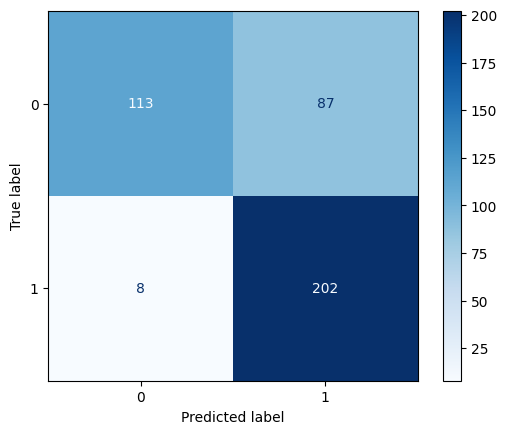

In [578]:
train(
    LogRegression(),
    "recall",
    {
        "alpha": [0.01, 0.1, 1, 2, 5],
        "tol": np.linspace(1e-6, 1e-3, 4),
        "eta0": [0.1, 1, 10, 20],
    }
)


Мы получили хорошее значение полноты, но плохое значение точности.

{'train_score': '0.84',
 'test_precision': '0.81',
 'test_recall': '0.83',
 'best_params': {'estimator__alpha': 0.01,
  'estimator__eta0': 0.1,
  'estimator__tol': 1e-06}}

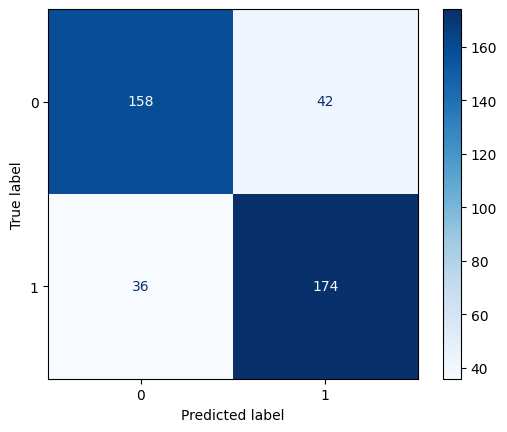

In [579]:
train(
    LogRegression(),
    "f1",
    {
        "alpha": [0.01, 0.1, 1, 2, 5],
        "tol": np.linspace(1e-6, 1e-3, 4),
        "eta0": [0.1, 1, 10, 20],
    }
)


Для F1 мы получили более плохое значение полноты, но более хорошее значение точности.

{'train_score': '0.85',
 'test_precision': '0.80',
 'test_recall': '0.83',
 'best_params': {'estimator__C': 0.5,
  'estimator__max_iter': 100,
  'estimator__tol': 1e-06}}

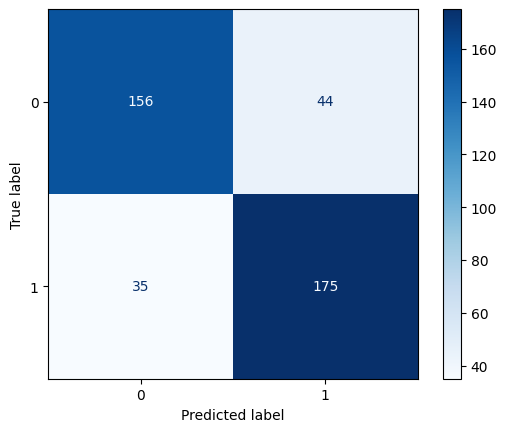

In [580]:
train(
    LogisticRegression(n_jobs=2, random_state=42),
    "recall",
    {
        "tol": [1e-6, 1e-5, 1e-4],
        "C": [0.1, 0.5, 0.75, 1, 2],
        "max_iter": [100, 150, 200],
    }
)


{'train_score': '0.84',
 'test_precision': '0.90',
 'test_recall': '0.91',
 'best_params': {'estimator__n_neighbors': 3}}

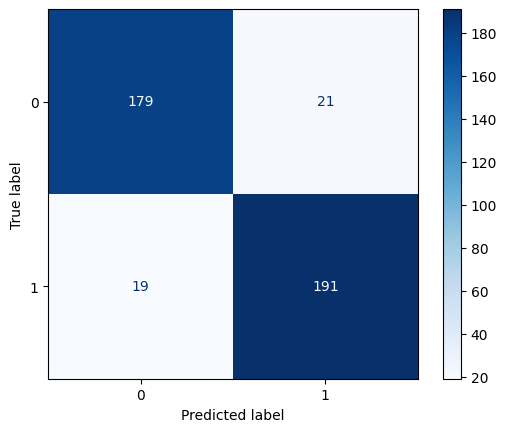

In [581]:
train(
    KNNClassifier(),
    "recall",
    {"n_neighbors": [3, 5, 7, 9]},
)


{'train_score': '0.96',
 'test_precision': '0.99',
 'test_recall': '0.97',
 'best_params': {'estimator__metric': 'manhattan',
  'estimator__n_neighbors': 5,
  'estimator__weights': 'distance'}}

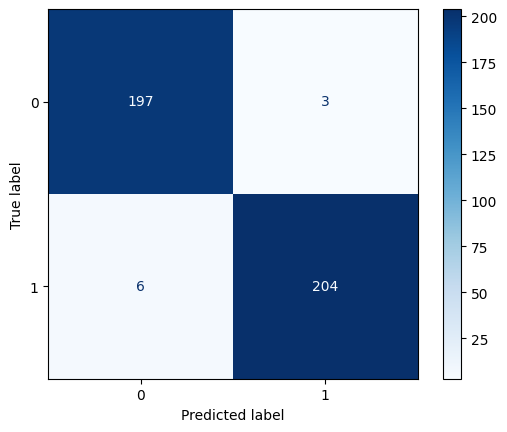

In [582]:
train(
    KNeighborsClassifier(n_jobs=2),
    "recall",
    {
        "n_neighbors": [3, 5, 7, 9],
        "weights": ["uniform", "distance"],
        "metric": ["cosine", "euclidean", "manhattan"],
    }
)


{'train_score': '0.95',
 'test_precision': '0.98',
 'test_recall': '0.93',
 'best_params': {'estimator__C': 10,
  'estimator__coef0': 1,
  'estimator__gamma': 'scale',
  'estimator__kernel': 'poly',
  'estimator__tol': 1e-06}}

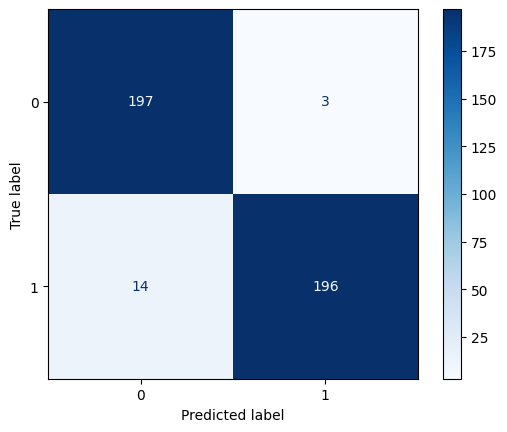

In [583]:
train(
    SVC(random_state=42),
    "f1",
    {
        "C": [0.01, 0.1, 1, 10],
        "kernel": ["linear", "poly", "rbf", "sigmoid"],
        "gamma": ["scale", "auto"],
        "coef0": [0, 1],
        "tol": [1e-6, 1e-5, 1e-4, 1e-3],
    }
)


{'train_score': '0.86',
 'test_precision': '0.78',
 'test_recall': '0.83',
 'best_params': {'estimator__var_smoothing': 1e-09}}

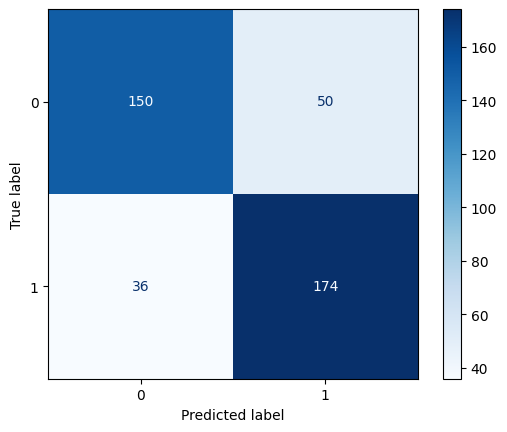

In [584]:
train(
    GaussianNB(),
    "recall",
    {
        "var_smoothing": [1e-9, 1e-8, 1e-5, 1e-3]
    },
)


{'train_score': '0.98',
 'test_precision': '1.00',
 'test_recall': '0.93',
 'best_params': {'estimator__criterion': 'gini',
  'estimator__max_depth': None,
  'estimator__max_leaf_nodes': 50,
  'estimator__min_samples_leaf': 1,
  'estimator__min_samples_split': 2,
  'estimator__min_weight_fraction_leaf': 0,
  'estimator__splitter': 'best'}}

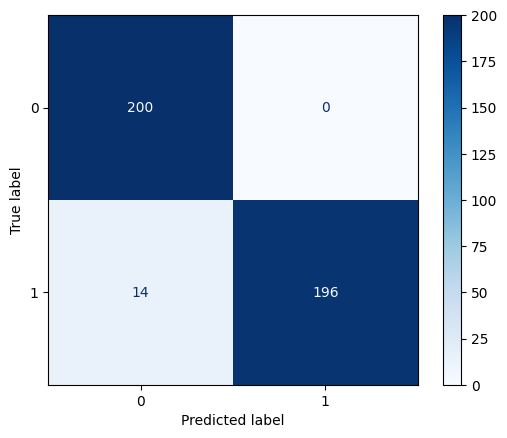

In [585]:
train(
    DecisionTreeClassifier(random_state=42),
    "recall",
    {
        "criterion": ["gini", "entropy", "log_loss"],
        "splitter": ["best", "random"],
        "max_depth": [None, 50, 100],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 5],
        "min_weight_fraction_leaf": [0, 0.1],
        "max_leaf_nodes": [None, 50, 500],
    },
)


По итогам сравнения можно сделать следующие выводы:

* Реализованный вручную метод `LogRegression` показал хорошее значение полноты, но при этом плохое значение точности. Однако при тренировке, нацеленной на F1, ухудшается полнота и улучшается точность.
* Реализованный вручную `KNNClassifier` показывает хорошую полноту и точность.
* `GaussianNB` и `LogisticRegression` показали достаточно плохие результаты (точность и полнота близки к 0.8)
* `SVC` и `DecisionTreeClassifier` показывают наилучший результат.


# Анализ второго датасета

Выполним аналогичный анализ для датасета ["Spaceship Titanic"](https://www.kaggle.com/competitions/spaceship-titanic/overview). Эти данные представляют информацию о пассажирах космического корабля "Титаник", который столкнулся с аномалией. Целевым является признак "Transported", который говорит о том, был ли пассажир унесён аномалией.

* PassengerId — уникальный id пассажира
* HomePlanet — планета, на которой пассажир взошёл на корабль
* CryoSleep — перемещался ли пассажир в состоянии криосна
* Cabin — номер каюты, вида: палуба/номер/сторона, сторона может быть P - левой, S - правой
* Destination — адрес назначения
* Age — возраст
* VIP — оплатил ли пассажир vip сервис
* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck — сколько денег пассажир потратил на разные услуги
* Name — имя и фамилия
* Transported — (целевой признак) — был ли пассажир перенесён аномалией в другое пространство

In [602]:
df = pd.read_csv("data/train.csv")
df.head(5)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [587]:
df.isnull().sum()


PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [588]:
df['Transported'].value_counts()


True     4378
False    4315
Name: Transported, dtype: int64

Примерно половина людей была унесена аномалией.


In [589]:
df.describe(include='all')


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
count,8693,8492,8476,8494,8511,8514.000000,8490,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8493,8693
unique,8693,3,2,6560,3,NaN,2,NaN,NaN,NaN,NaN,NaN,8473,2
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,NaN,False,NaN,NaN,NaN,NaN,NaN,Gollux Reedall,True
freq,1,4602,5439,8,5915,NaN,8291,NaN,NaN,NaN,NaN,NaN,2,4378
mean,NaN,NaN,NaN,NaN,NaN,28.827930,NaN,224.687617,458.077203,173.729169,311.138778,304.854791,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,14.489021,NaN,666.717663,1611.489240,604.696458,1136.705535,1145.717189,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,19.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,27.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,38.000000,NaN,47.000000,76.000000,27.000000,59.000000,46.000000,NaN,NaN


### Поиск закономерностей в данных

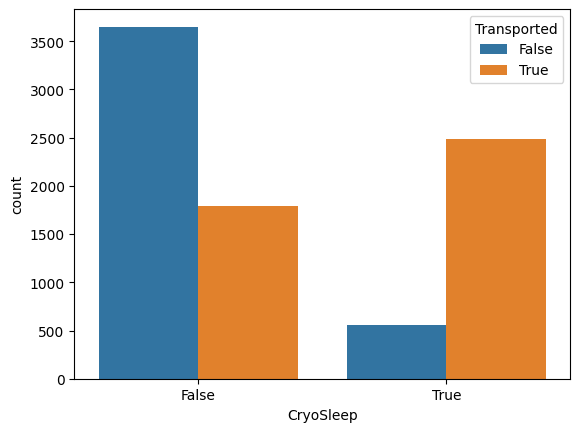

In [590]:
sns.countplot(x="CryoSleep", hue="Transported", data=df);


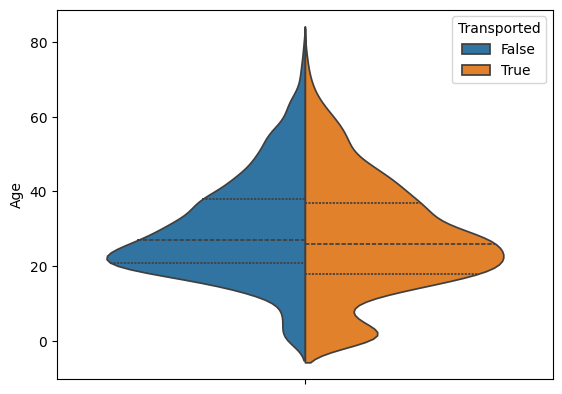

In [591]:
sns.violinplot(data=df, y="Age", hue="Transported", split=True,  inner="quart");


На данном графике изображено распределение по возрасту относительно признака "Transported". Для взрослых людей распределение примерно одинаковое, но для детей --- нет. А именно, дети имели куда меньший шанс быть унесёнными аномалией.

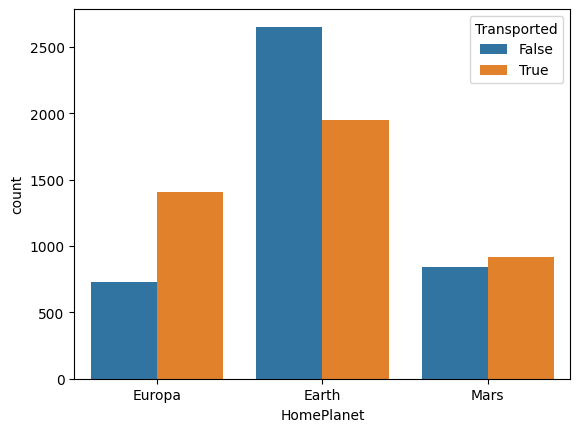

In [592]:
sns.countplot(data=df, hue="Transported", x="HomePlanet");


Из данного графика сложно сделать вывод о зависимости между признаком `HomePlanet` и целевым признаком.

### Трансформация данных

In [603]:
df[["deck", "num", "side"]] = df["Cabin"].str.split("/", expand=True)
df.drop(["Cabin"], axis=1, inplace=True)
df.head()


,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,deck,num,side
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0,P
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0,S
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0,S
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0,S
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1,S


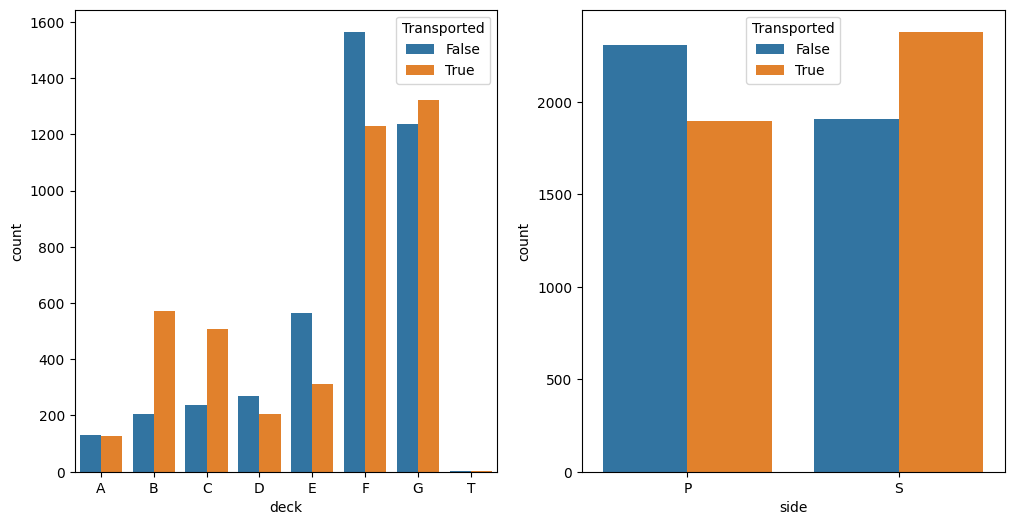

In [604]:
_, ax = plt.subplots(1, 2, figsize=(12,6))
sns.countplot(data=df, hue="Transported", x="deck", order="ABCDEFGT", ax=ax[0]);
sns.countplot(data=df, hue="Transported", x="side",  ax=ax[1]);


In [605]:
df[["group_id", "num_in_group"]] = df["PassengerId"].str.split("_", expand=True)
df.drop(["PassengerId"], axis=1, inplace=True)


In [ ]:
df["group_size"] = df.groupby(["group_id"])["group_id"].transform(len)


Аномалия уносила людей чаще с палуб B и C и с правого борта (S)

Выбросим те признаки, из которых не получится извлечь полезную информацию

In [595]:
df.drop(["HomePlanet", "Destination", "Name"], axis=1, inplace=True)


Создадим новый признак MoneySpent, обозначающий траты человека на борту

In [596]:
df["MoneySpent"] = sum([df["Spa"], df["VRDeck"], df["FoodCourt"], df["RoomService"], df["ShoppingMall"]])


In [597]:
for category in ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]:
    df.loc[df["CryoSleep"] == True, category] = df.loc[df["CryoSleep"] == True, category].fillna(0)


In [598]:
df[df["CryoSleep"] == True][["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].isnull().sum()


RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
dtype: int64

In [599]:
df.loc[df["CryoSleep"] == True,"VIP"] = df.loc[df["CryoSleep"] == True,"VIP"].fillna(False)
df[df["CryoSleep"] == True]["VIP"].isnull().sum()


0

In [600]:
df.replace({"side": {"S": 1, "P": 0}, "deck": {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "T": 8}}, inplace=True)
df.loc[df["MoneySpent"] > 0, "CryoSleep"] = df.loc[df["MoneySpent"] > 0, "CryoSleep"].fillna(False)


/tmp/ipykernel_52962/606257365.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap='RdYlGn')


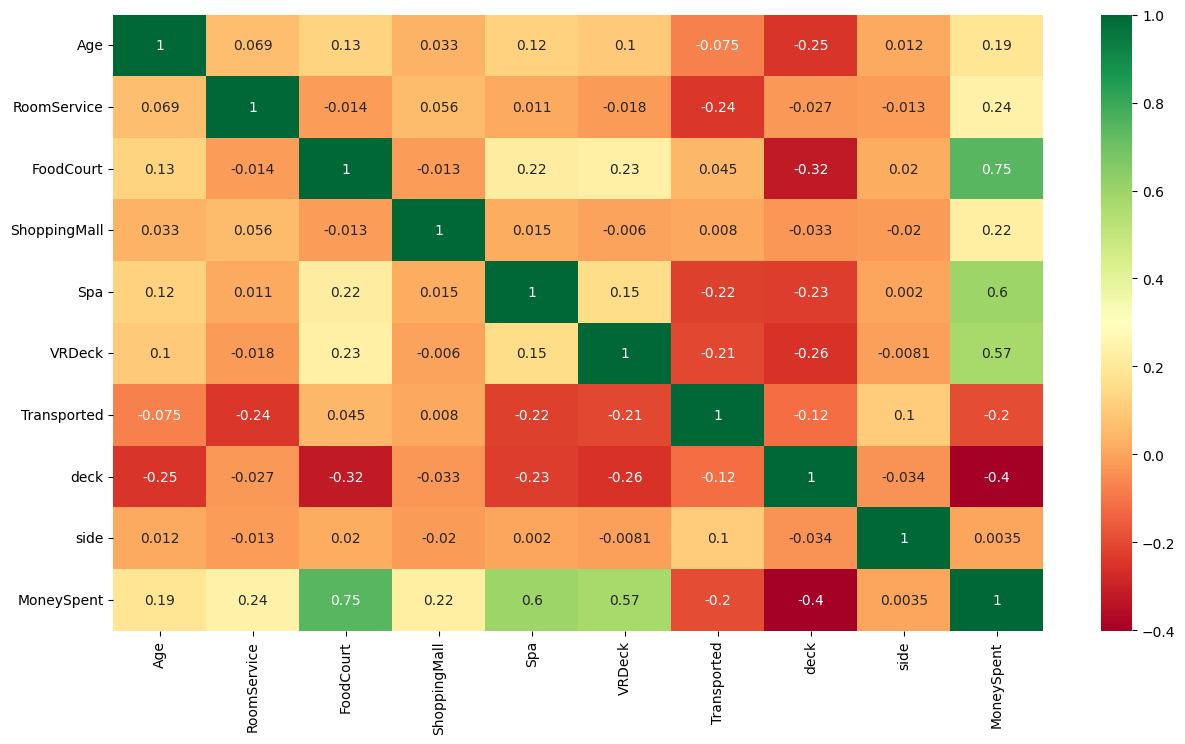

In [601]:

sns.heatmap(df.corr(), annot=True, cmap='RdYlGn')
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.show()



In [607]:
X = df.drop(columns=["Transported"])
y = df["Transported"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, random_state=42, stratify=y)


Для данного датасета также будем обращать внимание на метрику полноты (recall).